In [75]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

%matplotlib inline
plt.style.use('seaborn') #установка стиля matplotlib
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (10, 8) 

from sklearn import set_config, preprocessing # предобработка
set_config(transform_output='pandas')
from sklearn.model_selection import train_test_split # сплитование выборки
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from category_encoders import OneHotEncoder, BinaryEncoder

from statsmodels.tsa.stattools import adfuller

import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
data = pd.read_csv('../sp500sub.csv', index_col='Date', parse_dates=True)

Выбираю одну акцию и оставляю только Close

In [77]:
df = data.query('Name == "IBM"')[['Close']].copy()

In [78]:
df['Log_Close'] = np.log(df['Close'])
df['Log_Return'] = df['Log_Close'].diff()

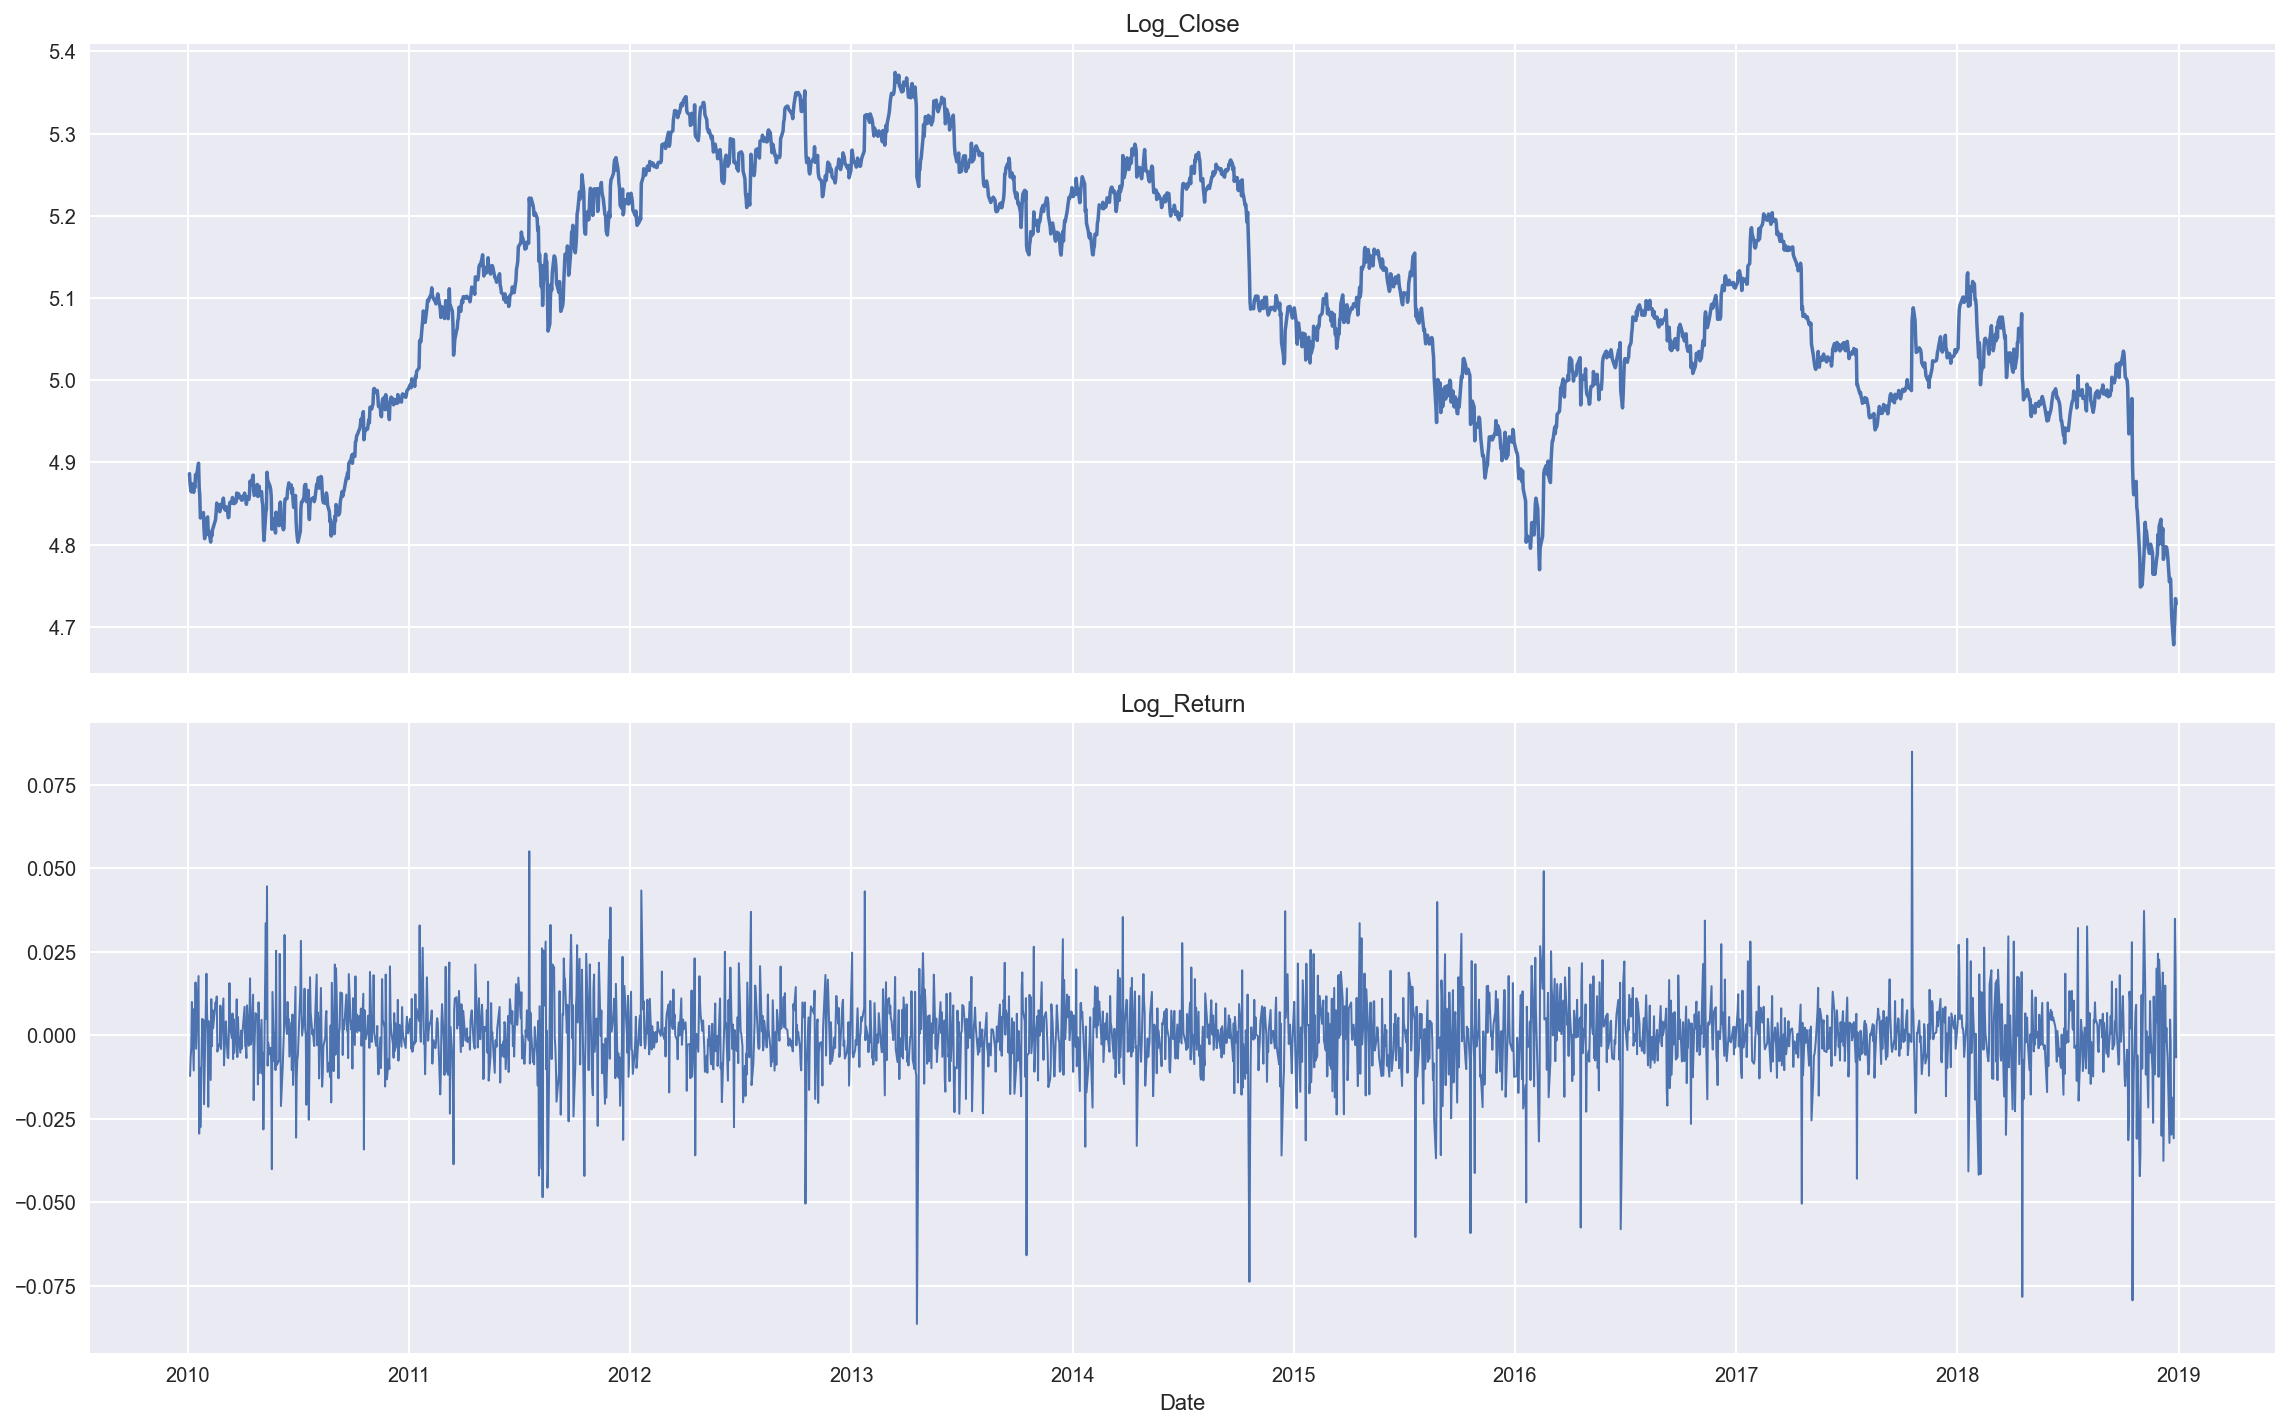

In [79]:
# Create a 2-row, 1-column subplot grid
fig, ax = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

# Convert index and columns to NumPy arrays
ind = df.index.to_numpy()
_0 = df['Log_Close'].to_numpy()
_1 = df['Log_Return'].to_numpy()

ax[0].plot(ind, _0)
ax[0].set_title('Log_Close')

ax[1].plot(ind, _1, linewidth=1)
ax[1].set_title('Log_Return')

# Set the x-axis label for the entire figure
plt.xlabel('Date')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

In [80]:
def adf(x, threshold=0.05):
    results = adfuller(x)
    
    print('Test-Statistic:', results[0])
    print('P-Value:', results[1])
    
    if results[1] < threshold:
        print('Stationary!')
    else:
        print('Non-Stationary')

In [81]:
# первое значение из ряда убираю т.к. после применения diff там теперь nan 
adf(df['Log_Return'].values[1:])

Test-Statistic: -47.094174011034774
P-Value: 0.0
Stationary!


Ряд стационарен

### Create Target
Размечаю данные, создаю категориальный бинарный признак логарифмического прироста. Если выросли за период то 1 иначе 0.

In [82]:
df['Tagret'] = np.where(df['Log_Return'] > 0, 1, 0)

### Split data

In [83]:
N_test = 252 # Сколько элементов в конце оставить на тестовую выборку, тут в днях получается
train = df.iloc[:-N_test]
test = df.iloc[-N_test:]

### Create supervised dataset
Трансформируя исходый временной ряд получаю датасеты X, y. Т.е. фактически cам генерирую/размечаю данные.

In [84]:
# первое значение из ряда убираю т.к. после применения diff там теперь nan 
series = df['Log_Return'].values[1:]
target = df['Tagret'].values[1:]

In [85]:
T = 21 # длина истории, пусть будет 21 день, котрая используется для прогноза на следующий день
N = len(series) - T # Num of samples in dataset

X = []
y = []

for t in range(N):
    X.append(series[t:t+T]) # first T elements
    y.append(target[t+T]) # next element for prediction

In [86]:
X = np.array(X).reshape(-1, T)
y = np.array(y)

In [87]:
print('X.shape:', X.shape, 'y.shape:', y.shape)

X.shape: (2241, 21) y.shape: (2241,)


Split dataset

In [88]:
X_train, X_test = X[:-N_test], X[-N_test:]
y_train, y_test = y[:-N_test], y[-N_test:]

### LR

In [89]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [90]:
model.score(X_train, y_train)

0.5093011563599799

In [91]:
model.score(X_test, y_test)

0.49603174603174605

Или вот так классическим путем, через получение векторов предсказаний

In [92]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [93]:
accuracy_score(y_train, y_train_pred)

0.5093011563599799

In [94]:
accuracy_score(y_test, y_test_pred)

0.49603174603174605

## SVC

In [95]:
model = SVC()
model.fit(X_train, y_train)

SVC()

In [96]:
model.score(X_train, y_train)

0.7551533433886375

In [97]:
model.score(X_test, y_test)

0.49603174603174605

Модель цепляется за шум и на тестовой выборке ничего не показывает

## Random Forest

In [98]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [99]:
model.score(X_train, y_train)

1.0

In [100]:
model.score(X_test, y_test)

0.5

У случайного леса на тренировочной выборке вообще 100% результат, он да, умееет переобучаться